In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact

from scipy.stats import spearmanr, pearsonr, kruskal
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import procrustes
from skbio.stats.distance import mantel, permanova, DistanceMatrix
from skbio.stats.ordination import pcoa
%matplotlib inline

In [70]:
metabo = pd.read_csv("data/Metabolome_BF.csv", encoding='unicode_escape')

metabo = metabo[metabo["Sample"].isna()==False]
metabo = metabo.drop(["Sample Description", "Sample Weight", "Date and Time"], axis=1)

metabo = metabo.set_index("Sample")

#Clean up column names
metabo.columns = [" ".join(col.split(" ")[:-4]) for col in list(metabo.columns)]

#Impute NQ as LLOQ/2
metabo.replace(to_replace="NQ",
               value=np.nan,
               inplace=True)

metabo.loc["LLOQ",:] = metabo.loc["LLOQ",:].astype(float)
metabo.loc["half LLOQ",:] = metabo.loc["LLOQ"]/2
metabo.iloc[2:-1,:] = metabo.iloc[2:-1,:].fillna(metabo.loc["half LLOQ",:])

#Drop ULOQ/LLOQ
metabo.drop(["half LLOQ","LLOQ","ULOQ"], inplace=True)

In [71]:
metabo.head()

,myristic acid (14:0),myristoleic acid (14:1n5),pentadecanoic acid (15:0),palmitic acid (16:0),palmitoleic acid (16:1n7),margaric acid (17:0),stearic acid (18:0),oleic acid (18:1n9),vaccenic acid (18:1n7),linoleic acid (18:2n6),...,eicosapentaenoic acid (20:5n3),behenic acid (22:0),erucic acid (22:1n9),cis-13-16-docosadienoic acid (22:2n6),adrenic acid (22:4n6),osbond acid (22:5n6),docosapentaenoic acid (22:5n3),docosahexaenoic acid (22:6n3),lignoceric acid (24:0),nervonic acid (24:1n9)
Sample,,,,,,,,,,,,,,,,,,,,,
B.F 1.1,0.601,0.48,0.408,10.5,0.8,0.385,3.81,3.09,0.8,6.4,...,0.8,0.793,0.112,0.48,0.48,0.48,0.8,1.6,0.878,0.8
B.F 1.2,4.990,0.282,4.770,50.7,1.51,2.560,11.80,14.00,3.82,6.84,...,0.8,3.000,0.476,0.308,0.48,0.48,0.8,1.6,6.410,1.97
B.F 1.3,8.810,0.491,7.540,106.0,2.35,4.420,30.20,40.90,8.11,8.64,...,0.8,3.300,0.848,0.785,1.31,0.48,2.16,2.86,7.800,2.52
B.F 2.1,6.250,0.131,4.510,93.8,2.36,2.420,17.20,29.50,5.53,13.7,...,0.8,2.100,0.582,0.379,0.793,0.973,1.51,3.08,4.650,1.39
B.F 2.2,7.310,0.165,4.960,111.0,2.50,2.860,22.80,36.80,6.49,15.0,...,0.8,2.680,0.608,0.425,0.946,0.48,0.8,4.44,6.510,1.99


In [72]:
metadata = pd.read_csv("data/metadata.tsv", sep="\t", index_col="Sampleid")

In [73]:
metadata = metadata.reindex(metabo.index)

In [74]:
for var in metabo.columns:
    metabo[var] = metabo[var].astype(float)

In [75]:
spear_time_volc = pd.DataFrame(index=metabo.columns, columns=["p","r"])

for lipid in metabo.columns:
    spear = spearmanr(metabo[lipid],
                      metadata["Timepoint"])
    
    spear_time_volc.loc[lipid, "p"] = spear.pvalue
    
    spear_time_volc.loc[lipid, "r"] = spear.correlation
    
spear_time_volc["-log10 p value"] = spear_time_volc["p"].apply(lambda x: -1*np.log10(x))

[(-0.8, 0.8), Text(0.5, 0, 'Spearman r')]

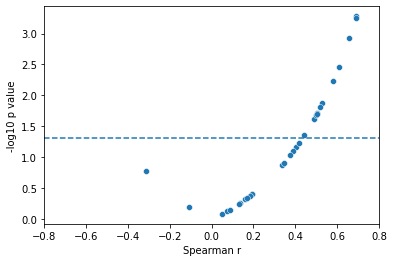

In [113]:
ax = sns.scatterplot(y="-log10 p value",x="r", data=spear_time_volc)

ax.axhline(-np.log10(0.05), ls="--")
ax.set(xlim=(-0.8,0.8), xlabel="Spearman r")

In [115]:
spear_time_volc.loc[spear_time_volc["p"]<0.05].sort_values(by="p")

,p,r,-log10 p value
cis-11-eicosaenoic acid (20:1n9),0.000525,0.690894,3.279873
"cis-11,14-eicosadienoic acid (20:2n6)",0.00056,0.688423,3.251752
alpha-linolenic acid (18:3n3),0.001203,0.657368,2.919715
myristic acid (14:0),0.003539,0.60678,2.451069
adrenic acid (22:4n6),0.005968,0.578877,2.224140
stearic acid (18:0),0.01352,0.529728,1.869030
oleic acid (18:1n9),0.015656,0.520097,1.805320
linoleic acid (18:2n6),0.019317,0.505814,1.714052
cis-13-16-docosadienoic acid (22:2n6),0.019794,0.504118,1.703462
erucic acid (22:1n9),0.020744,0.500834,1.683099


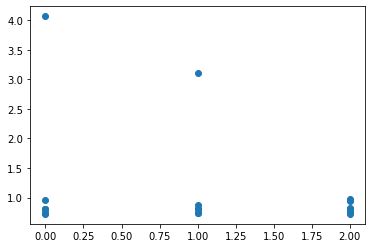

In [78]:
plt.scatter(y=metabo["mead acid (20:3n9)"], x=metadata["Timepoint"])

In [79]:
mead_df = pd.DataFrame(metabo["mead acid (20:3n9)"])
mead_df["Participant"] = [x.split(" ")[1][0] for x in mead_df.index]

[[<matplotlib.axis.XTick at 0x7fae15d92df0>,

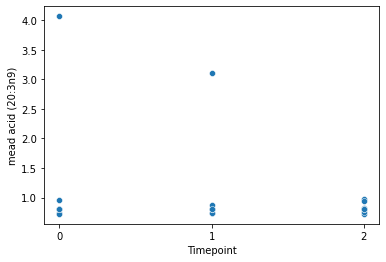

In [80]:
ax = sns.scatterplot(y=metabo["mead acid (20:3n9)"], x=metadata["Timepoint"])

ax.set(xticks=[0,1,2])

In [81]:
pear_time_volc = pd.DataFrame(index=metabo.columns, columns=["p","r"])

for lipid in metabo.columns:
    pear = pearsonr(metabo[lipid],
                      metadata["Timepoint"])
    
    pear_time_volc.loc[lipid, "p"] = pear[1]
    
    pear_time_volc.loc[lipid, "r"] = pear[0]
    
pear_time_volc["-log10 p value"] = pear_time_volc["p"].apply(lambda x: -1*np.log10(x))

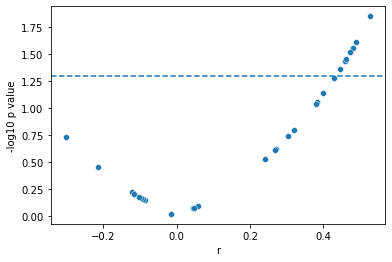

In [82]:
ax = sns.scatterplot(y="-log10 p value",x="r", data=pear_time_volc)

ax.axhline(-np.log10(0.05), ls="--")

<AxesSubplot:xlabel='Timepoint', ylabel='stearic acid (18:0)'>

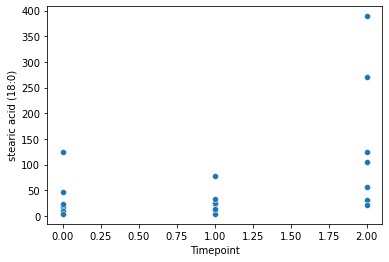

In [83]:
sns.scatterplot(y=metabo["stearic acid (18:0)"], x=metadata["Timepoint"])

In [84]:
pear_time_volc[pear_time_volc["p"]<0.05]

,p,r,-log10 p value
stearic acid (18:0),0.030056,0.473732,1.522073
oleic acid (18:1n9),0.036799,0.458021,1.434159
alpha-linolenic acid (18:3n3),0.02745,0.480554,1.561459
cis-11-eicosaenoic acid (20:1n9),0.014014,0.527395,1.853432
"cis-11,14-eicosadienoic acid (20:2n6)",0.030281,0.473163,1.518824
erucic acid (22:1n9),0.036663,0.458316,1.435777
cis-13-16-docosadienoic acid (22:2n6),0.034837,0.462342,1.457960
adrenic acid (22:4n6),0.02425,0.489671,1.615280
docosapentaenoic acid (22:5n3),0.043085,0.445292,1.365675


# Ordinations, Mantel, and PERMANOVA

In [85]:
metabo_braycurt = DistanceMatrix(squareform(pdist(metabo, metric="braycurtis")), ids=metabo.index)

In [86]:
metabo_pcoa = pcoa(metabo_braycurt, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01399391442838006 and the largest is 2.1598307072968215.
  warn(


In [87]:
metabo_pcoa.proportion_explained

PC1    0.584448
PC2    0.287275
PC3    0.044437
dtype: float64

### Participant

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

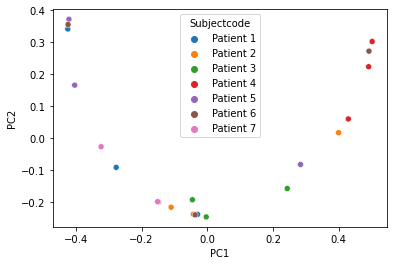

In [88]:
sns.scatterplot(x="PC1", y="PC2", hue=metadata["Subjectcode"], data=metabo_pcoa.samples)

In [89]:
metabo_braycurt = DistanceMatrix(squareform(pdist(metabo, metric="braycurtis")), ids=metabo.index)

permanova(metabo_braycurt, metadata["Subjectcode"])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      21
number of groups                  7
test statistic             2.105091
p-value                        0.04
number of permutations          999
Name: PERMANOVA results, dtype: object

previously:

>method name               PERMANOVA \
test statistic name        pseudo-F \
sample size                      21 \
number of groups                  7 \
test statistic             0.577544 \
p-value                       0.888 \
number of permutations          999 \
Name: PERMANOVA results, dtype: object

### Timepoint

In [116]:
#initialize empty distance matrix
dat = metadata["Timepoint"].dropna()
dim = dat.shape[0]
distm = np.empty((dim, dim))

#fill distance matrix
for i in range(dim):
    for j in range(dim):
        distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

distm = DistanceMatrix(distm, ids=dat.index)

#filter where we don't have data
microbiome_distm = DistanceMatrix(metabo_braycurt.to_data_frame().loc[dat.index,dat.index], 
                          ids=dat.index)
#do the mantel
man = mantel(microbiome_distm, 
            distm,
            method="spearman")

print("MANTEL TIMEPOINT METABOLOME")
print(f"p value: {man[1]}")
print(f"pseudo-F: {man[0]}")

MANTEL TIMEPOINT METABOLOME
p value: 0.03
pseudo-F: 0.16546399581077356


previously:

>MANTEL TIMEPOINT METABOLOME \
p value: 0.034 \
pseudo-F: 0.16546399581077356

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

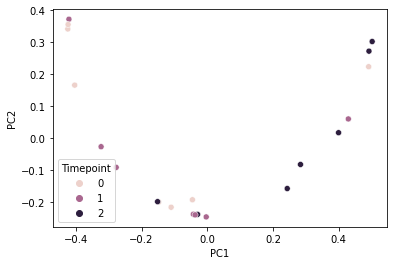

In [91]:
sns.scatterplot(x="PC1", y="PC2", hue=metadata["Timepoint"], data=metabo_pcoa.samples)

# Stacked Barplot

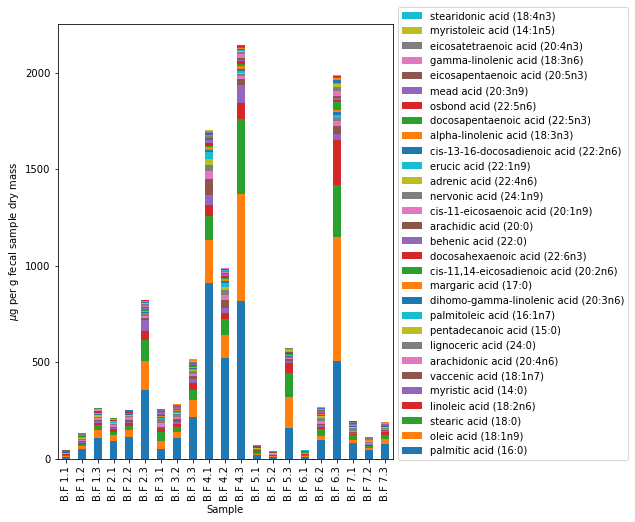

In [92]:
s = metabo.sum(axis=0)
ax = metabo[s.sort_values(ascending=False).index].plot(kind="bar", stacked=True)

#reverse the order of legend contents so it corresponds with the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1.05))

ax.set_ylabel(r"$\mu$g per g fecal sample dry mass")
plt.gcf().set_size_inches(6,8)
plt.show()

In [93]:
metabo.sum(axis=1)

Sample
B.F 1.1      45.670
B.F 1.2     133.716
B.F 1.3     265.256
B.F 2.1     213.333
B.F 2.2     255.375
B.F 2.3     823.605
B.F 3.1     259.793
B.F 3.2     286.581
B.F 3.3     516.142
B.F 4.1    1702.603
B.F 4.2     989.938
B.F 4.3    2146.865
B.F 5.1      72.611
B.F 5.2      40.896
B.F 5.3     573.118
B.F 6.1      43.377
B.F 6.2     267.355
B.F 6.3    1991.077
B.F 7.1     197.254
B.F 7.2     113.502
B.F 7.3     192.649
dtype: float64

In [94]:
pearsonr(metabo.sum(axis=1),
          metadata["Timepoint"])

(0.36765545049500126, 0.1010761270238276)

<AxesSubplot:xlabel='Timepoint'>

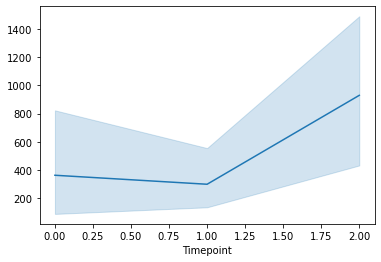

In [95]:
sns.lineplot(y=metabo.sum(axis=1),
             x=metadata["Timepoint"])

# Saturated vs unsaturated

In [96]:
saturated = []
unsaturated = []

for col in metabo.columns:
    if col.split(":")[-1]=="0)":
        saturated.append(col)
    else:
        unsaturated.append(col)

In [97]:
metabo["Saturated FA total"] = metabo[saturated].sum(axis=1)
metabo["Unsaturated FA total"] = metabo[unsaturated].sum(axis=1)

<AxesSubplot:>

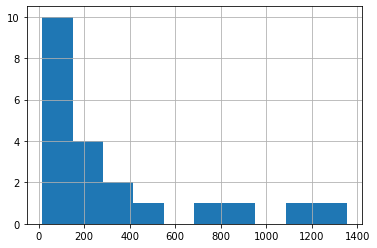

In [99]:
metabo["Saturated FA total"].hist()

<AxesSubplot:>

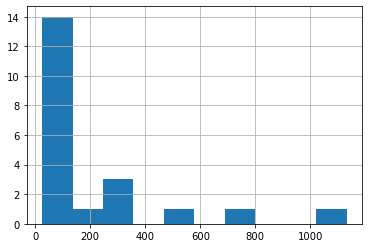

In [100]:
metabo["Unsaturated FA total"].hist()

In [101]:
spearmanr(metabo["Saturated FA total"],
          metadata["Timepoint"])

SpearmanrResult(correlation=0.491202756937505, pvalue=0.023743115999134926)

In [102]:
spearmanr(metabo["Unsaturated FA total"],
          metadata["Timepoint"])

SpearmanrResult(correlation=0.491202756937505, pvalue=0.023743115999134926)

In [103]:
pearsonr(metabo["Saturated FA total"],
          metadata["Timepoint"])

(0.3080552929266184, 0.17428682695855147)

In [104]:
pearsonr(metabo["Unsaturated FA total"],
          metadata["Timepoint"])

(0.41659444710070404, 0.06029648144703889)

<AxesSubplot:xlabel='Timepoint', ylabel='Saturated FA total'>

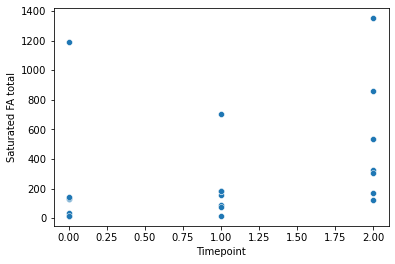

In [117]:
sns.scatterplot(y=metabo["Saturated FA total"],
                x=metadata["Timepoint"])

<AxesSubplot:xlabel='Timepoint', ylabel='Unsaturated FA total'>

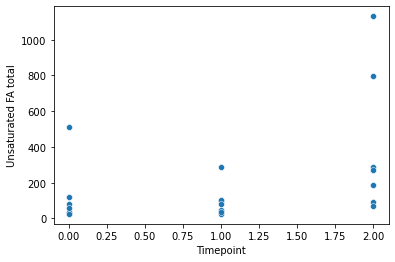

In [118]:
sns.scatterplot(y=metabo["Unsaturated FA total"],
                x=metadata["Timepoint"])

# Procrustes

In [105]:
tax_braycurt = Artifact.load("core-diversity-results/bray_curtis_distance_matrix.qza").view(DistanceMatrix)

In [106]:
tax_pcoa_coords = pd.DataFrame(pcoa(tax_braycurt).samples)[["PC1","PC2","PC3"]]
tax_pcoa_coords.index = list(tax_braycurt.ids)

metabo_pcoa_coords = pd.DataFrame(pcoa(metabo_braycurt).samples)[["PC1","PC2","PC3"]]
metabo_pcoa_coords.index = metabo.index

/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.012102740189118007 and the largest is 1.6333975100184703.
  warn(
/Users/johnsterrett/mambaforge/envs/qiime2-2022.2/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the No

In [107]:
mtx1, mtx2, disparity = procrustes(metabo_pcoa_coords,
                                   tax_pcoa_coords)
print(f'disparity: {disparity}')

disparity: 0.906653576249191


In [108]:
proplot = pd.concat([pd.DataFrame(mtx1),
                     pd.DataFrame(mtx2)])
proplot.columns = ["PC1","PC2","PC3"]
proplot["Dataset"] = ["microbiome"]*mtx1.shape[0] + ["metabolome"]*mtx2.shape[0]

Text(0.5, 1.0, 'Procrustes-transformed Bray-Curtis PCoA of Microbiome and Metabolome')

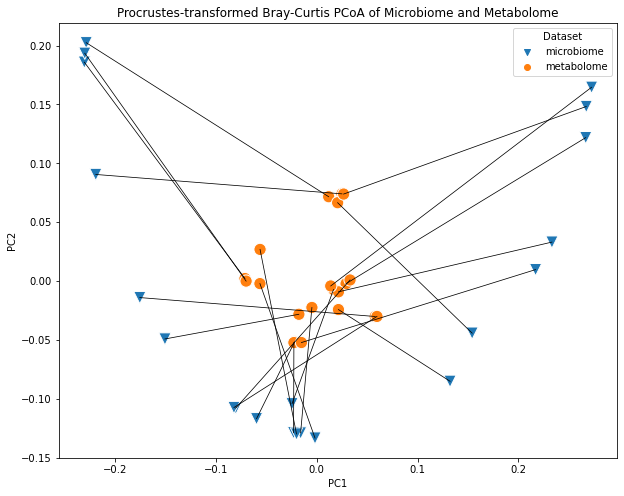

In [109]:
ax = sns.scatterplot(x="PC1",y="PC2",
                     style="Dataset",hue="Dataset",
                     data=proplot,
                     markers=["v","o"],
                     s=150)

for i in range(len(mtx1)):
    plt.plot([mtx1[i,0],mtx2[i,0]],
             [mtx1[i,1],mtx2[i,1]],
             c="black", linewidth=0.75)
    
plt.gcf().set_size_inches(10,8)
ax.set_title("Procrustes-transformed Bray-Curtis PCoA of Microbiome and Metabolome", fontsize="large")


In [110]:
rows, cols = metabo.shape
n=10000

disparities = []
for x in range(n):
    metabo_rand = metabo_pcoa_coords.sample(frac=1,axis=0).reset_index(drop=True)
    
    mtx1_rand, mtx2_rand, disparity_rand = procrustes(metabo_rand, tax_pcoa_coords)
    disparities.append(disparity_rand)

pval = (sum([disparity > d for d in disparities])+1)/(n+1)

print(f'Procrustean randomization test pval: {pval}')

Procrustean randomization test pval: 0.4530546945305469


Text(0, 0.5, 'Occurrences during 10,000 permutations')

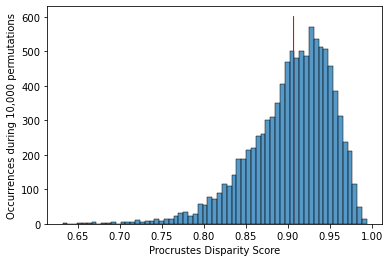

In [111]:
ax = sns.histplot(disparities)
ax.arrow(disparity,0,
         0,600,
         width=0.0001,
         color="red") 
ax.set_xlabel("Procrustes Disparity Score")
ax.set_ylabel("Occurrences during 10,000 permutations")
